In [ ]:
import os
import random
import csv
from pathlib import Path
import zipfile
import sys
import pkgutil

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import seaborn as sns

# ========================== 1. CONFIG (KAGGLE) ==========================
SEED = 42

# Prefer TPU (torch_xla) if available; else CUDA; else CPU
USE_TPU = True

def _print_runtime_diagnostics():
    print('--- Runtime diagnostics ---')
    print('Python:', sys.version.split()[0])
    print('Torch :', torch.__version__)
    print('CUDA available:', torch.cuda.is_available())
    print('TPU_NAME:', os.environ.get('TPU_NAME'))
    print('XRT_TPU_CONFIG:', os.environ.get('XRT_TPU_CONFIG'))
    print('torch_xla importable:', bool(pkgutil.find_loader('torch_xla')))
    print('--------------------------\n')

_print_runtime_diagnostics()

IS_XLA = False
xm = None
if USE_TPU:
    try:
        import torch_xla.core.xla_model as xm  # type: ignore
        IS_XLA = True
    except Exception as e:
        IS_XLA = False
        print('TPU requested but torch_xla is not available.')
        print('torch_xla import error:', repr(e))
        print('What this usually means on Kaggle:')
        print('  1) The session was started before switching Accelerator -> restart session, then Run from Cell 2.')
        print('  2) The TPU runtime is provisioned, but Kaggle image does not include PyTorch/XLA (torch_xla).')
        print('     In that case, PyTorch cannot use TPU unless you install torch_xla (often requires Internet ON).')
        print('     Quick workaround: switch Accelerator to GPU (P100/T4) for PyTorch training.')
        print()

if IS_XLA:
    device = xm.xla_device()
    print('Device: xla (TPU)')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)
    if str(device) == 'cpu':
        print('Note: CPU is being used because TPU is unavailable and CUDA is not available.')

IS_CUDA = (not IS_XLA) and torch.cuda.is_available()

# Kaggle paths
KAGGLE_INPUT = Path('/kaggle/input')
KAGGLE_WORKING = Path('/kaggle/working')

# Optional: if your dataset is attached but the auto-detect fails, set this to the dataset subfolder name.
# Example: DATASET_SUBDIR = 'your-dataset-slug'  (the folder directly under /kaggle/input)
DATASET_SUBDIR = None  # or a string

def _safe_listdir(path: Path, limit: int = 100):
    try:
        items = sorted(list(path.iterdir()))
    except Exception as e:
        print(f'Could not list {path}: {e}')
        return []
    if len(items) > limit:
        print(f'Listing {path}: showing first {limit} of {len(items)} entries')
        items = items[:limit]
    else:
        print(f'Listing {path}: {len(items)} entries')
    for p in items:
        suffix = '/' if p.is_dir() else ''
        print(' -', p.name + suffix)
    return items

def _is_train_name(name: str) -> bool:
    n = name.strip().lower()
    return n == 'train' or n.startswith('train') or n in {'training', 'trainset', 'train_set'}

def _is_test_name(name: str) -> bool:
    n = name.strip().lower()
    return n == 'test' or n.startswith('test') or n in {'testset', 'test_set'}

def _find_train_test_pair(root: Path):
    """Return (base_dir, train_dir, test_dir) if found, else None."""
    if not root.exists() or not root.is_dir():
        return None

    # 1) direct children, flexible train/test naming
    children = [p for p in root.iterdir() if p.is_dir()]
    train_dir = next((p for p in children if _is_train_name(p.name)), None)
    test_dir = next((p for p in children if _is_test_name(p.name)), None)
    if train_dir and test_dir:
        return root, train_dir, test_dir

    # 2) common nesting: root/data/(Train,Test)
    data_dir = next((p for p in children if p.name.strip().lower() == 'data'), None)
    if data_dir:
        return _find_train_test_pair(data_dir)

    return None

def _maybe_unzip_here(dataset_dir: Path, extract_to: Path) -> Path | None:
    """If dataset_dir contains zip(s), unzip to extract_to and return extract_to; else None."""
    if not dataset_dir.exists() or not dataset_dir.is_dir():
        return None
    zips = sorted([p for p in dataset_dir.glob('*.zip') if p.is_file()])
    if not zips:
        return None

    extract_to.mkdir(parents=True, exist_ok=True)
    print(f'Found {len(zips)} zip file(s). Extracting to: {extract_to}')
    for zp in zips:
        print(' - extracting', zp.name)
        with zipfile.ZipFile(zp, 'r') as zf:
            zf.extractall(extract_to)
    return extract_to

def find_data_root_kaggle(input_root: Path) -> Path:
    """Find a folder that contains Train/ and Test/ (robust detection; supports zipped datasets)."""
    if not input_root.exists():
        raise FileNotFoundError(f'Kaggle input folder not found: {input_root}')

    print('\n--- Debug: /kaggle/input contents ---')
    _safe_listdir(input_root, limit=200)

    dataset_dirs = [p for p in input_root.iterdir() if p.is_dir()]
    if not dataset_dirs:
        raise FileNotFoundError('No dataset folders found under /kaggle/input. Please use Add data in Kaggle.')

    # If user specifies a dataset subdir, try it first.
    if isinstance(DATASET_SUBDIR, str) and DATASET_SUBDIR.strip():
        dataset_dirs = [input_root / DATASET_SUBDIR.strip()]

    for dataset_dir in sorted(dataset_dirs):
        print('\n--- Debug: dataset folder ---')
        print('Dataset dir:', dataset_dir)
        _safe_listdir(dataset_dir, limit=200)

        pair = _find_train_test_pair(dataset_dir)
        if pair:
            base_dir, _, _ = pair
            return base_dir

        extracted = _maybe_unzip_here(dataset_dir, KAGGLE_WORKING / 'dataset_unzipped')
        if extracted:
            print('\n--- Debug: extracted folder (top-level) ---')
            _safe_listdir(extracted, limit=200)
            pair = _find_train_test_pair(extracted)
            if pair:
                base_dir, _, _ = pair
                return base_dir

        print('\nDeep searching for Train/Test under', dataset_dir)
        train_candidates = []
        test_candidates = []
        for p in dataset_dir.glob('**/*'):
            if p.is_dir():
                if _is_train_name(p.name):
                    train_candidates.append(p)
                elif _is_test_name(p.name):
                    test_candidates.append(p)

        for train_path in train_candidates:
            parent = train_path.parent
            siblings = [s for s in parent.iterdir() if s.is_dir()]
            sib_test = next((s for s in siblings if _is_test_name(s.name)), None)
            if sib_test:
                return parent

        if extracted:
            print('\nDeep searching for Train/Test under extracted', extracted)
            train_candidates = []
            test_candidates = []
            for p in extracted.glob('**/*'):
                if p.is_dir():
                    if _is_train_name(p.name):
                        train_candidates.append(p)
                    elif _is_test_name(p.name):
                        test_candidates.append(p)
            for train_path in train_candidates:
                parent = train_path.parent
                siblings = [s for s in parent.iterdir() if s.is_dir()]
                sib_test = next((s for s in siblings if _is_test_name(s.name)), None)
                if sib_test:
                    return parent

    found_names = [p.name for p in dataset_dirs]
    raise FileNotFoundError(
        'Could not find Train/ and Test/ under /kaggle/input. '
        'Please attach a dataset that includes Train/ and Test/ with class subfolders. '
        f'Found dataset folders: {found_names}'
    )

BASE_DATA_DIR = find_data_root_kaggle(KAGGLE_INPUT)
pair = _find_train_test_pair(BASE_DATA_DIR)
if not pair:
    raise FileNotFoundError(f'Internal error: BASE_DATA_DIR has no Train/Test: {BASE_DATA_DIR}')
_, TRAIN_DIR, TEST_DIR = pair

print('\nDetected BASE_DATA_DIR:', BASE_DATA_DIR)
print('Train dir:', TRAIN_DIR)
print('Test dir :', TEST_DIR)

NUM_CLASSES = 9
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
T_MAX = 20
OVERSAMPLE_FACTOR = 5
PATIENCE = 6
USE_FOCAL = True

# DataLoader settings: XLA is picky; keep workers=0 and pin_memory=False on TPU
NUM_WORKERS = 4
PIN_MEMORY = True if IS_CUDA else False

BASE_PATH = KAGGLE_WORKING / 'VGG16_Results'
LOG_DIR = BASE_PATH / 'logs'
CKPT_DIR = BASE_PATH / 'checkpoints'
BEST_DIR = BASE_PATH / 'best_model'
RESULT_DIR = BASE_PATH / 'results'

LOG_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)
BEST_DIR.mkdir(parents=True, exist_ok=True)
RESULT_DIR.mkdir(parents=True, exist_ok=True)

LOG_CSV = LOG_DIR / 'training_log.csv'

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ========================== 2. LABEL MAP ==========================
label_map = {
    0: 'actinic keratosis',
    1: 'basal cell carcinoma',
    2: 'dermatofibroma',
    3: 'melanoma',
    4: 'nevus',
    5: 'pigmented benign keratosis',
    6: 'seborrheic keratosis',
    7: 'squamous cell carcinoma',
    8: 'vascular lesion',
}

--- Runtime diagnostics ---
Python: 3.11.13
Torch : 2.6.0+cu124
CUDA available: False
TPU_NAME: None
XRT_TPU_CONFIG: None
torch_xla importable: False
--------------------------

TPU requested but torch_xla is not available.
torch_xla import error: ModuleNotFoundError("No module named 'torch_xla'")
What this usually means on Kaggle:
  1) The session was started before switching Accelerator -> restart session, then Run from Cell 2.
  2) The TPU runtime is provisioned, but Kaggle image does not include PyTorch/XLA (torch_xla).
     In that case, PyTorch cannot use TPU unless you install torch_xla (often requires Internet ON).
     Quick workaround: switch Accelerator to GPU (P100/T4) for PyTorch training.

Device: cpu
Note: CPU is being used because TPU is unavailable and CUDA is not available.

--- Debug: /kaggle/input contents ---
Listing /kaggle/input: 1 entries
 - skin-cancer9-classesisic/

--- Debug: dataset folder ---
Dataset dir: /kaggle/input/skin-cancer9-classesisic
Listing /kagg

In [30]:
# ========================== 3. RAW DATASET ==========================
train_dataset_raw = datasets.ImageFolder(str(TRAIN_DIR))
test_dataset = datasets.ImageFolder(str(TEST_DIR))

print('Train samples:', len(train_dataset_raw))
print('Test  samples:', len(test_dataset))
print('Class folders (ImageFolder):', train_dataset_raw.classes)

# ========================== 4. TRANSFORMS / AUGMENT ==========================
class RandomAugmentationPerImage:
    def __init__(self):
        self.augmentations = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(40),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        ]
        self.resize = transforms.Resize((224, 224))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    def __call__(self, img):
        img = self.resize(img)
        for aug in self.augmentations:
            if torch.rand(1) < 0.5:
                img = aug(img)
        img = self.to_tensor(img)
        img = self.normalize(img)
        return img

transform_train = RandomAugmentationPerImage()
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

Train samples: 2239
Test  samples: 118
Class folders (ImageFolder): ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


--- Original Train Distribution ---
0 (actinic keratosis): 114 samples | 5.09%
1 (basal cell carcinoma): 376 samples | 16.79%
2 (dermatofibroma): 95 samples | 4.24%
3 (melanoma): 438 samples | 19.56%
4 (nevus): 357 samples | 15.94%
5 (pigmented benign keratosis): 462 samples | 20.63%
6 (seborrheic keratosis): 77 samples | 3.44%
7 (squamous cell carcinoma): 181 samples | 8.08%
8 (vascular lesion): 139 samples | 6.21%


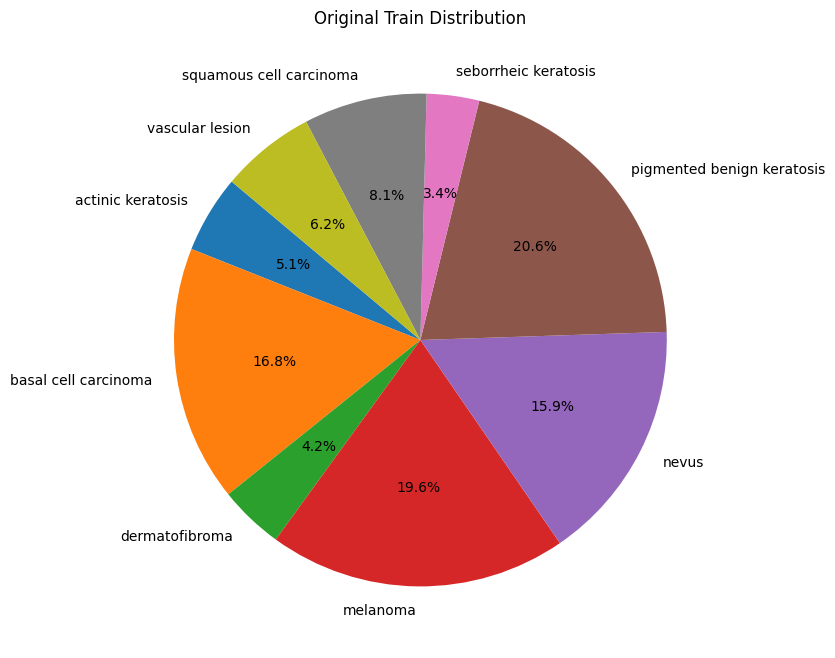

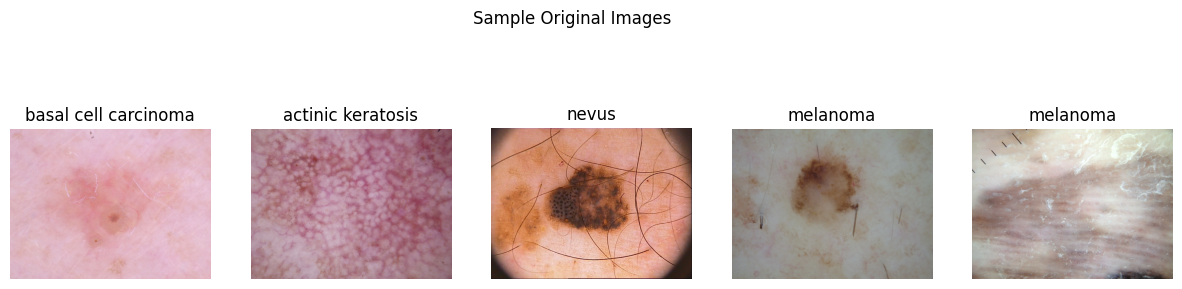

In [31]:
# ========================== 5. PLOT SAMPLE & CLASS DISTRIBUTION ==========================
def plot_class_distribution(labels, label_map, title='Class Distribution'):
    counter = Counter(labels)
    total = sum(counter.values())
    print(f'--- {title} ---')
    for i in range(len(label_map)):
        count = counter.get(i, 0)
        print(f'{i} ({label_map[i]}): {count} samples | {count / total * 100:.2f}%')
    counts = [counter.get(i, 0) for i in range(len(label_map))]
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=[label_map[i] for i in range(len(label_map))], autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

original_labels = [label for _, label in train_dataset_raw.imgs]
plot_class_distribution(original_labels, label_map, title='Original Train Distribution')

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i, ax in enumerate(axes):
    img, label = train_dataset_raw[random.randint(0, len(train_dataset_raw) - 1)]
    ax.imshow(img)
    ax.set_title(label_map[label])
    ax.axis('off')
plt.suptitle('Sample Original Images')
plt.show()

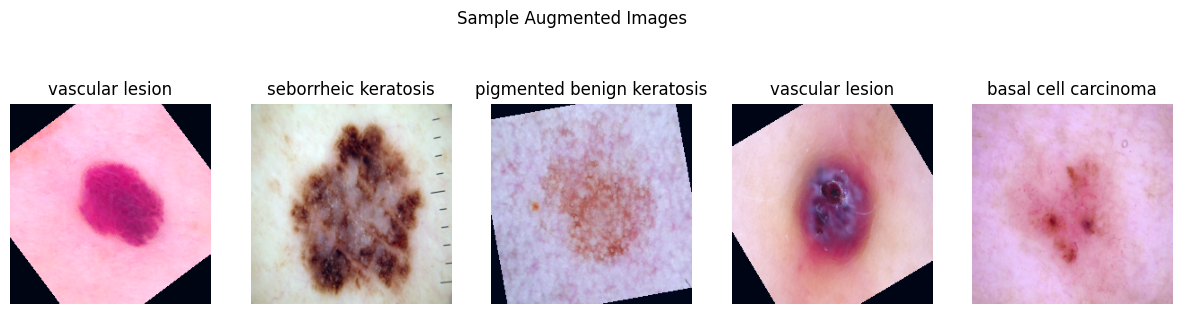

In [32]:
# ========================== 6. OVERSAMPLING ==========================
targets = [train_dataset_raw.imgs[i][1] for i in range(len(train_dataset_raw.imgs))]
class_counts = Counter(targets)
max_count = max(class_counts.values()) * OVERSAMPLE_FACTOR
weights_per_class = {cls: max_count / count for cls, count in class_counts.items()}
sample_weights = np.array([weights_per_class[t] for t in targets])
indices = np.random.choice(
    len(targets),
    size=len(targets) * OVERSAMPLE_FACTOR,
    replace=True,
    p=sample_weights / sample_weights.sum(),
)

class OversampledDataset(Dataset):
    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.base_dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset_full = OversampledDataset(train_dataset_raw, indices, transform=transform_train)

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i, ax in enumerate(axes):
    img, label = train_dataset_full[random.randint(0, len(train_dataset_full) - 1)]
    img_np = img.permute(1, 2, 0).numpy()
    denom = (img_np.max() - img_np.min())
    img_np = (img_np - img_np.min()) / (denom if denom != 0 else 1.0)
    ax.imshow(img_np)
    ax.set_title(label_map[label])
    ax.axis('off')
plt.suptitle('Sample Augmented Images')
plt.show()

--- Train Distribution After Oversampling ---
0 (actinic keratosis): 722 samples | 11.52%
1 (basal cell carcinoma): 709 samples | 11.31%
2 (dermatofibroma): 692 samples | 11.04%
3 (melanoma): 722 samples | 11.52%
4 (nevus): 696 samples | 11.10%
5 (pigmented benign keratosis): 705 samples | 11.25%
6 (seborrheic keratosis): 664 samples | 10.59%
7 (squamous cell carcinoma): 682 samples | 10.88%
8 (vascular lesion): 677 samples | 10.80%


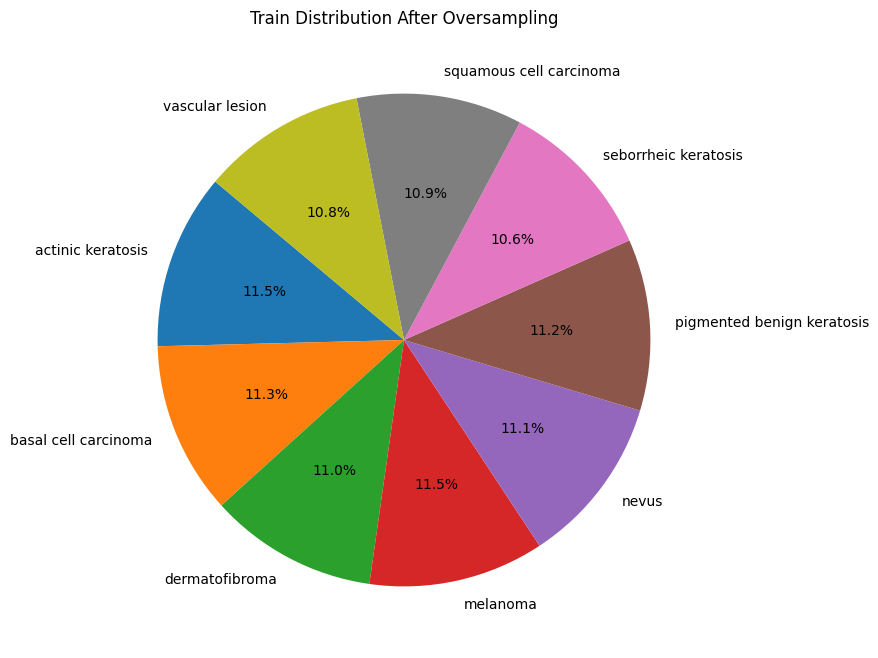

In [33]:
# ========================== 7. SPLIT TRAIN / VAL ==========================
oversampled_imgs = [train_dataset_raw.imgs[i] for i in indices]
paths, labels = zip(*oversampled_imgs)
paths = np.array(paths)
labels = np.array(labels)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.3, stratify=labels, random_state=SEED
)

class CustomDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = np.array(paths)
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        label = int(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, label

train_loader = DataLoader(
    CustomDataset(train_paths, train_labels, transform=transform_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

val_loader = DataLoader(
    CustomDataset(val_paths, val_labels, transform=transform_val),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

test_paths = [p for p, _ in test_dataset.imgs]
test_labels = [l for _, l in test_dataset.imgs]
test_loader = DataLoader(
    CustomDataset(test_paths, test_labels, transform=transform_val),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

plot_class_distribution(train_labels, label_map, title='Train Distribution After Oversampling')

In [34]:
# ========================== 8. CLASS WEIGHTS & LOSS ==========================
train_labels_for_weights = train_labels.astype(int)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_for_weights),
    y=train_labels_for_weights,
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce = nn.CrossEntropyLoss(weight=self.weight, reduction='none')(inputs, targets)
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        if self.reduction == 'mean':
            return loss.mean()
        if self.reduction == 'sum':
            return loss.sum()
        return loss

criterion = FocalLoss(gamma=2.0, weight=class_weights) if USE_FOCAL else nn.CrossEntropyLoss(weight=class_weights)

# ========================== 9. EARLY STOPPING ==========================
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_f1 = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, f1):
        if self.best_f1 is None:
            self.best_f1 = f1
            return
        if f1 < self.best_f1 + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_f1 = f1
            self.counter = 0

In [35]:
# ========================== 10. VGG16 MODEL ==========================
# Kaggle often runs with Internet OFF by default.
# To avoid runtime crashes, we only use pretrained weights if they are already cached locally.

VGG16_WEIGHT_FILENAME = 'vgg16-397923af.pth'

def _torchvision_weights_cached(filename: str) -> bool:
    try:
        hub_dir = Path(torch.hub.get_dir())
    except Exception:
        return False
    return (hub_dir / 'checkpoints' / filename).exists()

class VGG16Model(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super().__init__()

        if pretrained:
            if not _torchvision_weights_cached(VGG16_WEIGHT_FILENAME):
                print('PRETRAINED=True but VGG16 weights are not cached. Using random init (weights=None).')
                self.vgg16 = models.vgg16(weights=None)
            else:
                try:
                    weights = models.VGG16_Weights.DEFAULT
                    self.vgg16 = models.vgg16(weights=weights)
                    print('Loaded ImageNet pretrained weights (VGG16) from cache.')
                except Exception as e:
                    print('Warning: failed to load cached pretrained weights; using random init. Error:', repr(e))
                    self.vgg16 = models.vgg16(weights=None)
        else:
            self.vgg16 = models.vgg16(weights=None)

        # Freeze early layers
        for param in self.vgg16.features[:20].parameters():
            param.requires_grad = False

        # Replace classifier
        num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Sequential(
            nn.Dropout(0.5)
            ,nn.Linear(num_features, 512)
            ,nn.ReLU()
            ,nn.Dropout(0.3)
            ,nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.vgg16(x)

# Set pretrained to False by default for Kaggle no-internet safety
PRETRAINED = False
model = VGG16Model(num_classes=NUM_CLASSES, pretrained=PRETRAINED).to(device)
print(f'Model loaded on {device}')
print(f'Total parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Model loaded on cpu
Total parameters: 136362825
Trainable parameters: 131087369


In [36]:
# ========================== 11. TRAIN / EVAL FUNCTIONS ==========================
# TPU (XLA) support: use xm.optimizer_step on TPU
try:
    import torch_xla.core.xla_model as xm  # type: ignore
    _HAS_XLA = True
except Exception:
    xm = None
    _HAS_XLA = False

_IS_XLA_DEVICE = _HAS_XLA and ('xla' in str(device))

def train_one_epoch(model, loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch} [TRAIN]')
    for i, (imgs, labels) in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        if _IS_XLA_DEVICE:
            xm.optimizer_step(optimizer, barrier=True)
            xm.mark_step()
        else:
            optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=running_loss / (i + 1), acc=correct / total)
    return running_loss / len(loader), correct / total

def eval_one_epoch(model, loader, criterion, device, epoch):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        loop = tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch} [VAL]')
        for i, (imgs, labels) in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss / (i + 1), acc=correct / total)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    return running_loss / len(loader), correct / total, macro_f1

In [37]:
# ========================== 12. TRAINING LOOP ==========================
# TPU (XLA) safe checkpoint save
try:
    import torch_xla.core.xla_model as xm  # type: ignore
    _HAS_XLA = True
except Exception:
    xm = None
    _HAS_XLA = False

_IS_XLA_DEVICE = _HAS_XLA and ('xla' in str(device))

def _save_ckpt(state_dict, path: Path):
    if _IS_XLA_DEVICE:
        xm.save(state_dict, str(path))
    else:
        torch.save(state_dict, path)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX)
early_stopper = EarlyStopping(patience=PATIENCE)

best_f1 = 0.0
best_epoch = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'f1': []}

with open(LOG_CSV, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'macro_f1'])

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
    val_loss, val_acc, val_macro_f1 = eval_one_epoch(model, val_loader, criterion, device, epoch)

    scheduler.step()
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['f1'].append(val_macro_f1)

    with open(LOG_CSV, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc, val_macro_f1])

    if epoch % 10 == 0:
        ckpt_path = CKPT_DIR / f'model_epoch_{epoch}.pt'
        _save_ckpt(model.state_dict(), ckpt_path)
        print(' Saved checkpoint:', ckpt_path)

    if val_macro_f1 > best_f1:
        best_f1 = val_macro_f1
        best_epoch = epoch
        best_path = BEST_DIR / 'best_model_vgg16.pt'
        _save_ckpt(model.state_dict(), best_path)
        print(f' Best model updated at epoch {epoch} | F1={best_f1:.4f}')

    print(
        f'Epoch {epoch}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
        f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Macro F1: {val_macro_f1:.4f}'
    )

    early_stopper(val_macro_f1)
    if early_stopper.early_stop:
        print('>>> Early stopping triggered. Stopping training.')
        break

print('\nTraining completed. Best Epoch =', best_epoch, '| Best F1 =', best_f1)

Epoch 1 [TRAIN]:  98%|█████████▊| 192/196 [49:12<01:01, 15.38s/it, acc=0.114, loss=1.74] 


KeyboardInterrupt: 

In [ ]:
# ========================== 13. PLOT METRICS ==========================
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['f1'], label='Macro F1')
plt.title('Macro F1 Curve')
plt.legend()

plt.tight_layout()
plot_path = RESULT_DIR / 'training_curves_vgg16.png'
plt.savefig(plot_path)
print('Saved:', plot_path)
plt.show()

In [ ]:
# ========================== 14. CONFUSION MATRIX & TEST ==========================
best_model_path = BEST_DIR / 'best_model_vgg16.pt'
if best_model_path.exists():
    # TPU-safe: load weights onto CPU first
    model.load_state_dict(torch.load(best_model_path, map_location='cpu'))
    model.to(device)
    print('Loaded best model from', best_model_path)
else:
    print('Best model not found yet at:', best_model_path)

def plot_confusion(loader, title, save_path):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.values(), yticklabels=label_map.values(), cmap='Blues')
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.savefig(save_path)
    print('Saved:', save_path)
    plt.show()

plot_confusion(val_loader, 'Validation Confusion Matrix (VGG16)', RESULT_DIR / 'val_conf_matrix_vgg16.png')
plot_confusion(test_loader, 'Test Confusion Matrix (VGG16)', RESULT_DIR / 'test_conf_matrix_vgg16.png')

In [ ]:
# ========================== 15. DETAILED EVALUATION ==========================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

report = classification_report(all_labels, all_preds, target_names=list(label_map.values()))
print('\nClassification Report (VGG16):\n', report)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.values(), yticklabels=label_map.values(), cmap='Blues')
plt.title('Confusion Matrix (Validation - VGG16)')
plt.ylabel('True')
plt.xlabel('Pred')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

counter = Counter(all_labels)
print('\nNumber of samples per class in validation set:')
for i, name in label_map.items():
    print(f'{name}: {counter[i]}')

y_test_bin = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))
y_score_bin = label_binarize(all_preds, classes=list(range(NUM_CLASSES)))

plt.figure(figsize=(12, 10))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label_map[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class (Validation - VGG16)')
plt.legend(loc='lower right')
plt.show()